## Effect of Warmstarting the Hyperparameter Search

Before adding hyperparameter search option to the Experiment Graph, we perform a simple analysis where we select the one pipeline and for every execution we add the hyperparameters and the final accuracy to the Trial object of the hypernet. Afterwards, we perform a search using a predefined budget to find the best set of parameters.
We compare the result, with the vanilla version, where the Trial object is empty and report the quality and time to achieve the certain level of quality.

In [1]:
from openml import datasets, tasks, runs, flows, setups, config, evaluations
from workloadoptimization.essentials import Component, ExperimentObject, ExperimentGraph, ExperimentParser
from workloadoptimization.hyperopt_helper import TrialConverter
from workloadoptimization.openml_helper import OpenMLReader
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import uuid
import networkx as nx
import sklearn
from networkx.drawing.nx_agraph import graphviz_layout
from openmlstudy14.preprocessing import ConditionalImputer
from matplotlib2tikz import save as tikz_save
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

In [4]:
flow = flows.get_flow(flow_id=7707)
# Hack for changing the sklearn version dependecy as it does not affect the pipelines
flow.dependencies = u'sklearn==0.19.1\nnumpy>=1.6.1\nscipy>=0.9'
for v in flow.components.itervalues():
    v.dependencies = u'sklearn==0.19.1\nnumpy>=1.6.1\nscipy>=0.9'
task = tasks.get_task(task_id=31)
pipeline = flows.flow_to_sklearn(flow)

In [5]:
def extractExperiments(filePath, taskIds, flowIds):
    openMLReader = OpenMLReader()
    if os.path.isfile(filePath):
        return pd.read_pickle(filePath)
    frames = []
    for t in taskIds:
        for f in flowIds:
            frames.append(openMLReader.getTopRuns(-1,f,t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(filePath)
    return Experiments

# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extractExperiments('meta/hyper-opt-experiment-31-7707-all', [31], [7707])

In [13]:
OPENML_FLOWS = {}
FLOW_IDS = Experiments.flow_id.unique()
for f in FLOW_IDS:
    try:
        #print f
        fl = flows.get_flow(f)
        OPENML_FLOWS[f] = fl 
    except:
        print 'error for {}'.format(f)
parser = ExperimentParser()
experimentObjects = parser.extractOpenMLFlows(Experiments, OPENML_FLOWS)

In [14]:
# Find the range of all the hyperparameters for setting up the search space
param_range = {}
for e in experimentObjects:
    for k,v in e.extractParams().iteritems():
        if param_range.has_key(k):
            param_range[k].append(v)
        else:
            param_range[k] = [v]

In [15]:
# Find the hyperparameters with constant values so we can set them once and do not include them in the search space
CONSTANT_PARAMS = {}
DYNAMIC_PARAMS = []
for k in param_range.keys():
    try:
        size = len(set(param_range[k]))
        if size == 1:
            CONSTANT_PARAMS[k] = param_range[k][0]
        else:
            DYNAMIC_PARAMS.append(k)
    except: 
        CONSTANT_PARAMS[k] = param_range[k][0]    
        #print k,'error'
print 'Dynamic hyperparameters: {}'.format(DYNAMIC_PARAMS)

Dynamic hyperparameters: ['classifier__tol', 'classifier__gamma', 'classifier__C', 'imputation__strategy', 'classifier__degree', 'classifier__coef0', 'classifier__shrinking', 'classifier__kernel']


Based on the list of the parameters in the experiments these are the feasable ranges (or categories) of the parameters.
- classifier__tol 1.0509652110524482e-05 0.09706102908291375
- classifier__gamma 3.122280314190532e-05 7.998532268538166
- classifier__C 0.03213680700039348 32547.418063576853
- imputation__strategy {u'"mean"', u'"median"', u'"most_frequent"'}
- classifier__degree {u'1', u'2', u'3', u'4', u'5'}
- classifier__coef0 -0.9942534412466477 0.9975887639931769
- classifier__shrinking True, False

In [16]:
# construct the search space
from hyperopt import hp

# Parameter search space
space = {}
# between 1.0509652110524482e-05 0.09706102908291375
space['classifier__tol'] = hp.lognormal('classifier__tol',-7, 1)
# between 3.122280314190532e-05 7.998532268538166
space['classifier__gamma'] = hp.lognormal('classifier__gamma',0.0001, 1.3)
# One of True or False
space['classifier__C'] = hp.lognormal('classifier__C',2.5, 3)
# choice
space['imputation__strategy'] = hp.choice('imputation__strategy', [u'mean', u'median', u'most_frequent'])
# choice
space['classifier__degree'] = hp.choice('classifier__degree', [1, 2, 3, 4, 5])
# Between -0.9942534412466477 0.9975887639931769
space['classifier__coef0'] = hp.uniform('classifier__coef0', -1, 1)
# True or False
space['classifier__shrinking'] = hp.choice('classifier__shrinking',[True, False])

In [17]:
# set the constant parameters and define the objective function
pipeline.set_params(**CONSTANT_PARAMS)
def objective(params):
    print '.',
    # seems when tol is big (greater than 1) scikit learn throws an exception
    # I couldn't find a way to cap a value in the search space of hyperopt, 
    # this is the alternative solution
    if params['classifier__tol'] > 0.2:
        params['classifier__tol'] = 0.2
    pipeline.set_params(**params)
    try:
        pipeline.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
    accuracy = pipeline.score(X_test, y_test)
    #print 'accuracy = {}'.format(accuracy)
    return 1 - accuracy

In [18]:
# load the dataset
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices,test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
target=dataset.default_target_attribute,
return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [19]:
# sort based on the loss
sortedObjects = sorted(experimentObjects, key=lambda eo: 1 - eo.quality, reverse=True)

In [22]:
from hyperopt import fmin, tpe, Trials, rand
def hyperParamExperiment(trialsDatabase, numberOfExperiments, numberOfEvals):
    losses = np.empty([0, numberOfEvals])
    INITIAL_SIZE = len(trialsDatabase.trials)
    
    for i in range(numberOfExperiments):
        print ''
        print 'Experiment {}'.format(i + 1),
        trials = Trials()
        trials.insert_trial_docs(trialsDatabase.trials)
        trials.refresh() 
        
        fmin(objective,
                space,
                algo=tpe.suggest,
                max_evals=INITIAL_SIZE + numberOfEvals,
                trials=trials)
        
        newTrials = Trials()
        newTrials.insert_trial_docs(trials.trials[INITIAL_SIZE:])
        newTrials.refresh() 
        losses = np.insert(losses, i ,np.array(newTrials.losses()) , 0)  
    return losses

In [20]:
# Random selection from the sorted list
trialConverter = TrialConverter()
warmTrialsRandomSelection = trialConverter.trialsFromExperimentObjects(space, sortedObjects)
INITIAL_SIZE = len(warmTrials.trials)
warmLosses = hyperParamExperiment(warmTrials, 10,100)

NameError: name 'warmLosses' is not defined

In [23]:
# Vanilla
trialConverter = TrialConverter()
warmTrials = trialConverter.trialsFromExperimentObjects(space, sortedObjects)
INITIAL_SIZE = len(warmTrials.trials)
warmLosses = hyperParamExperiment(warmTrials, 10,100)

Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully Added an Item
Succesfully 


Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 4 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 5 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [13]:
coldTrials = Trials()    
coldLosses = hyperParamExperiment(coldTrials, 10,100)


Experiment 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 4 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Experiment 5 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [183]:
warmAvg = np.average(warmLosses,axis=0)
coldAvg = np.average(coldLosses,axis=0)

In [184]:
ExperimentAverages = pd.DataFrame({'No':coldAvg,'Yes':warmAvg}).reset_index()
ExperimentAverages.columns= ['Trial','No','Yes']
ExperimentAverages.head()
melted = ExperimentAverages.melt('Trial', var_name='Warmstarting', value_name='Loss')

In [190]:
ExperimentAverages.head()

,Trial,No,Yes
0,0,0.295,0.256
1,1,0.300,0.236
2,2,0.300,0.240
3,3,0.295,0.237
4,4,0.300,0.234


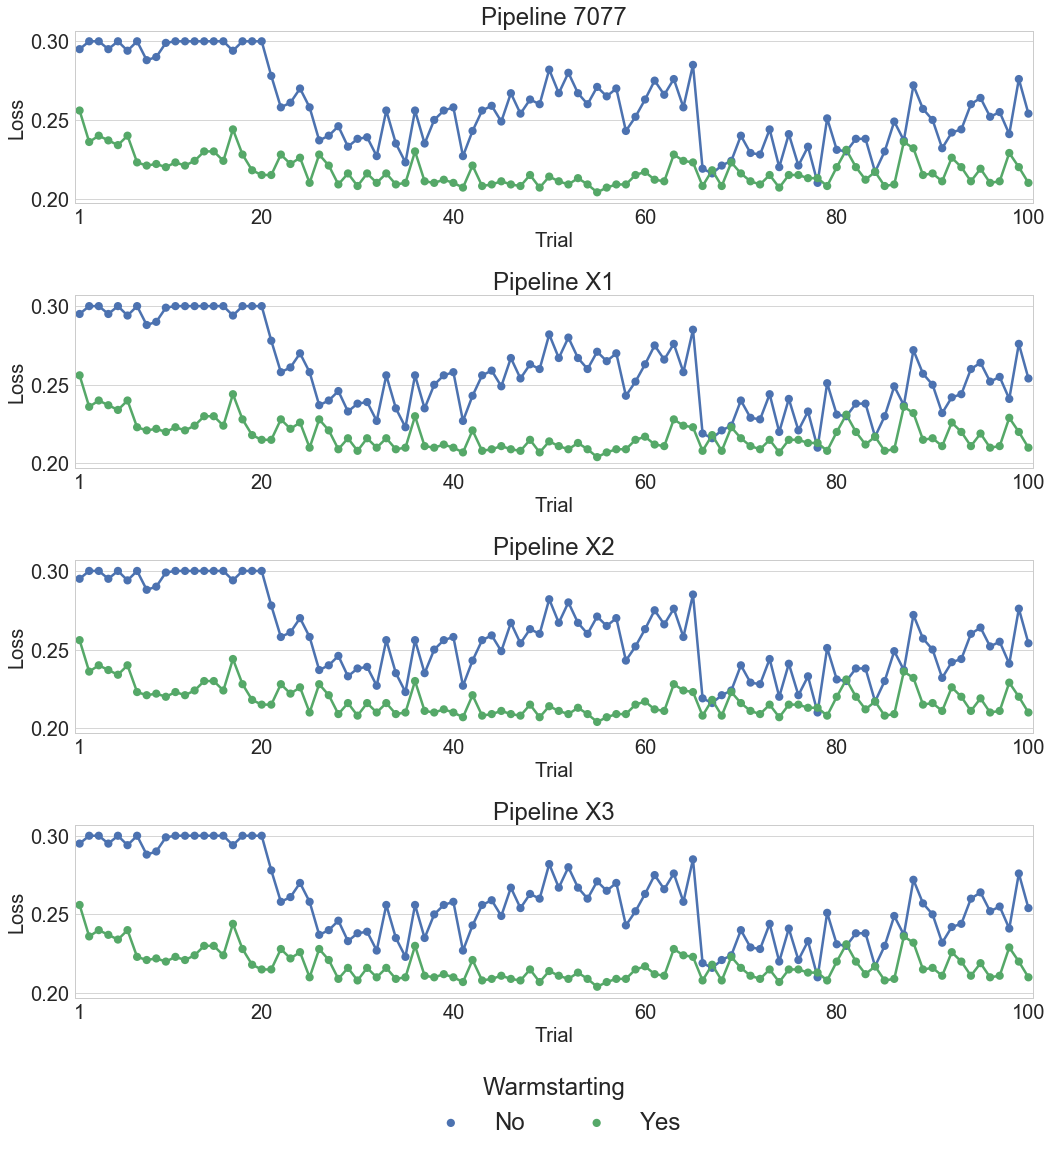

In [186]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
axes = [ax1,ax2,ax3,ax4]
pipelines = ['7707','X1','X2','X3']
for i in range(len(pipelines)):
    g = sns.factorplot(data=melted, 
                       x = 'Trial', 
                       y = 'Loss', 
                       hue = 'Warmstarting', 
                       size=8, aspect=2,ax = axes[i], legend=False, legend_out = False)
    axes[i].set_ylabel('Loss', fontsize=20)
    axes[i].set_xlabel('Trial', fontsize=20)
    axes[i].set(xticks=[0,19,39,59,79,99])
    axes[i].set_title('Pipeline {}'.format(pipelines[i]), fontsize = 24)
    axes[i].set_xticklabels(['1','20','40','60','80','100'], fontsize = 20)
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    #axes[i].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.,)
    axes[i].legend_.remove()
    plt.close(g.fig)
    
legend = ax4.legend(title = 'Warmstarting',
           bbox_to_anchor=(0.5, -.4),
           loc='upper center',
           borderaxespad=0.,
           fancybox = True,
           shadow=True,
           ncol = 2, 
           fontsize = 24)
plt.setp(legend.get_title(),fontsize = 24)
plt.tight_layout()
plt.savefig('figures/task31-cold-starting-warm-avgtrials.eps', format='eps', dpi=1000, bbox_inches='tight')

In [191]:
pipelines = ['7707','X1','X2','X3']
warms = np.repeat(len(set(np.where(warmLosses == np.min(warmLosses))[0])),4)
colds = np.repeat(len(set(np.where(coldLosses == 0.18999999999999995)[0])),4)
counts = pd.DataFrame({'Pipeline':pipelines,'Yes':warms,'No':colds}).melt('Pipeline', var_name='Warmstarting', value_name='Count')

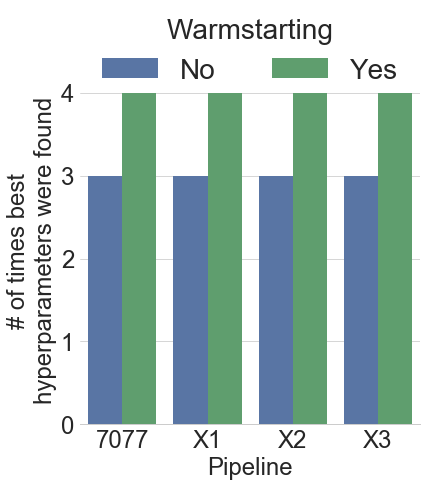

In [232]:
g = sns.factorplot(x="Pipeline", y="Count", hue="Warmstarting", data=counts,
                   size=6, kind="bar", legend= False)
g.set_ylabels('# of times best\nhyperparameters were found', fontsize = 24)
g.set_xlabels('Pipeline', fontsize=24)
g.set_xticklabels( fontsize = 24)
g.set(yticks=range(max(counts['Count'])+1))
g.set_yticklabels(range(max(counts['Count'])+1),fontsize = 24)
g.despine(left = True)
legend = g.ax.legend(title = 'Warmstarting',
           bbox_to_anchor=(0.5, 1.2),
           loc='upper center',
           borderaxespad=0.,
           fancybox = True,
           shadow=True,
           ncol = 2,
           fontsize = 28)
plt.setp(legend.get_title(),fontsize = 28)

plt.savefig('figures/task31-cold-starting-warm-besthyperparametersfound.eps', format='eps', dpi=1000, bbox_inches='tight')

## Comparison of the Accuracy for Warm and Cold Trials
In the experiment, we warm started the Trials object with 500 points from the OpenML repository and run the optimization process 100 times.
Figure above shows that using the existing experiments to warm start the Trials object for the bayesian optimization reduces the average loss of the subsequent trials (cold start = 0.256, warm start = 0.217).
Moreover, the best result (0.20) was found slightly earlier in warm start (after 17 iterations) when compared to the cold start (25 iterations).
However, running the experiments for longer trials (500) sometimes results in cold start achieving a better result. I believe, wamr starting results in local minima and forces the search to focus more on exploitation rather than exploration.
We should address the problem of local minima and propose solutions for fixing it.


## Conclusion
Warm starting for bayesian optimization certainly shows promising result. We must address some of its issues and perform more experiments on different datasets and pipelines.

## Appendix

In [ ]:
# darw the distributino of the error rate for individual parameters
def drawPlots(targetTrial):
    plt.figure(figsize=(10,10))
    plt.subplot(3,3,1)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__tol'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__tol')
    plt.subplot(3,3,2)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__gamma'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__gamma')
    plt.subplot(3,3,3)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__C'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__C')
    plt.subplot(3,3,4)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__degree'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__degree')
    plt.subplot(3,3,5)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__coef0'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__coef0')
    plt.subplot(3,1,3)
    ax = sns.regplot(np.array(range(len(targetTrial.losses()))), np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('Trials vs Quality over time')

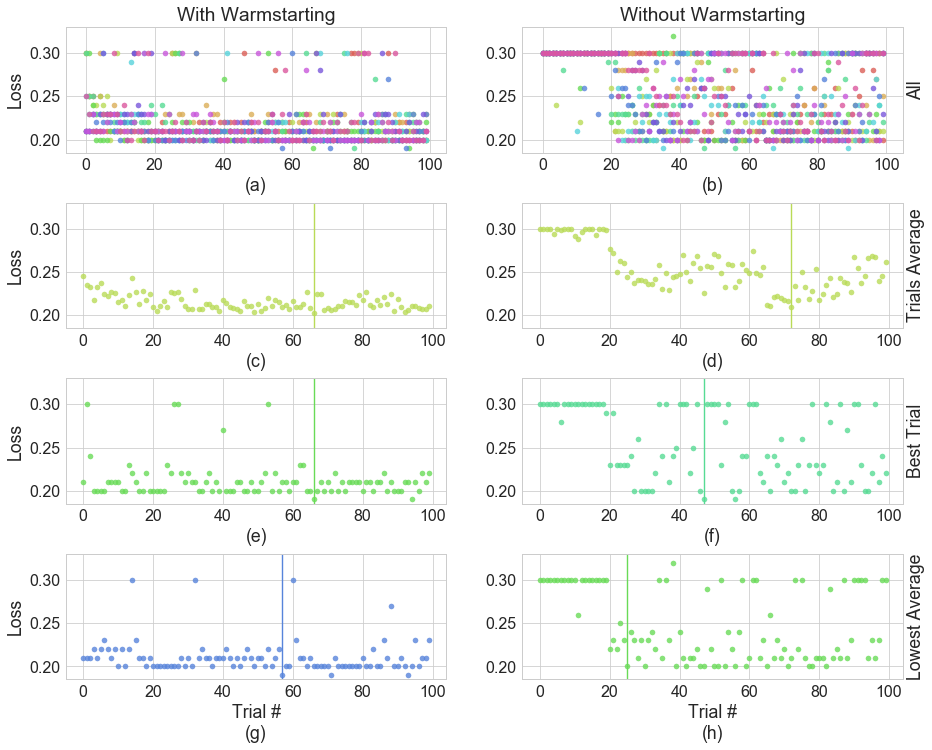

In [15]:
plt.figure(figsize=(15,12))
# ALL PLOTS
## warm
plt.subplot(4,2,1)
plt.subplots_adjust(hspace = 0.4)
for i in range(warmLosses.shape[0]):
    ax = sns.regplot(x = np.array(range(len(warmLosses[i]))), y = warmLosses[i], fit_reg=False, color=sns.color_palette("hls", 10)[i])
    ax.set_ylim(0.185,0.33)
    ax.set_ylabel('Loss')
    ax.set_title('With Warmstarting')
    ax.set_xlabel('(a)')
## cold
plt.subplot(4,2,2)
for i in range(coldLosses.shape[0]):
    ax = sns.regplot(x = np.array(range(len(coldLosses[i]))), y = coldLosses[i], fit_reg=False, color=sns.color_palette("hls", 10)[i])
    ax.set_ylim(0.185,0.33)
    ax.set_title('Without Warmstarting')
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('All')
    ax.set_xlabel('(b)')

# Average pointwise
## warm
plt.subplot(4,2,3)
warmAvg = np.average(warmLosses,axis=0)
ax = sns.regplot(x = np.array(range(len(warmAvg))), y = warmAvg, fit_reg=False, color=sns.color_palette("hls", 10)[2])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(warmAvg),color=sns.color_palette("hls", 10)[2])
ax.set_ylim(0.185,0.33)
ax.set_ylabel('Loss')
ax.set_xlabel('(c)')
## cold
plt.subplot(4,2,4)
coldAvg = np.average(coldLosses,axis=0)
ax = sns.regplot(x = np.array(range(len(coldAvg))), y = coldAvg, fit_reg=False, color=sns.color_palette("hls", 10)[2])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(coldAvg),color=sns.color_palette("hls", 10)[2])
ax.set_ylim(0.185,0.33)
ax.yaxis.set_label_position("right")
ax.set_ylabel('Trials Average')
ax.set_xlabel('(d)')

# Experiment with Best Value
## warm
plt.subplot(4,2,5)
bestWarmIndex = np.where(warmLosses == np.min(warmLosses))[0][0]
warmBest = warmLosses[bestWarmIndex]
ax = sns.regplot(x = np.array(range(len(warmBest))), y = warmBest, fit_reg=False, color=sns.color_palette("hls", 10)[bestWarmIndex])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(warmBest),color=sns.color_palette("hls", 10)[bestWarmIndex])
ax.set_ylim(0.185,0.33)
ax.set_ylabel('Loss')
ax.set_xlabel('(e)')
## cold
plt.subplot(4,2,6)
bestColdIndex = np.where(coldLosses == np.min(coldLosses))[0][0]
coldBest = coldLosses[bestColdIndex]
ax = sns.regplot(x = np.array(range(len(coldBest))), y = coldBest, fit_reg=False, color=sns.color_palette("hls", 10)[bestColdIndex])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(coldBest),color=sns.color_palette("hls", 10)[bestColdIndex])
ax.set_ylim(0.185,0.33)
ax.set_xlabel('(f)')
ax.yaxis.set_label_position("right")
ax.set_ylabel('Best Trial')

# Lowest AVG EXPR
## Warm
plt.subplot(4,2,7)
bestWarmIndex = np.argmin(np.average(warmLosses, axis=1))
warmBest = warmLosses[bestWarmIndex]
ax = sns.regplot(x = np.array(range(len(warmBest))), y = warmBest, fit_reg=False, color=sns.color_palette("hls", 10)[bestWarmIndex])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(warmBest),color=sns.color_palette("hls", 10)[bestWarmIndex])
ax.set_ylim(0.185,0.33)
ax.set_xlabel('Trial #\n(g)')
ax.set_ylabel('Loss')
## cold
plt.subplot(4,2,8)
bestColdIndex = np.argmin(np.average(coldLosses, axis=1))
coldBest = coldLosses[bestColdIndex]
ax = sns.regplot(x = np.array(range(len(coldBest))), y = coldBest, fit_reg=False, color=sns.color_palette("hls", 10)[bestColdIndex])
plt.vlines(ymin=0.185, ymax=0.33 , x = np.argmin(coldBest),color=sns.color_palette("hls", 10)[bestColdIndex])
ax.set_ylim(0.185,0.33)
ax.set_xlabel('Trial #\n(h)')
ax.yaxis.set_label_position("right")
ax.set_ylabel('Lowest Average')

plt.savefig('figures/10-experiments-trials100-task31.eps', format='eps', dpi=1000, bbox_inches='tight')